# Allen Deviation

Gyro Noise Paramenters:

- Angular Random Walk (ARW): $deg/\sqrt{hr}$
    - Standard Dev of drift due to noise = $ARW \cdot \sqrt{time}$
    - Thus, if ARW is small, then gyro drift over time is small
- Bias Instability: $deg/hr$
    - All sensors have bias and typically assume it is constant
    - However, if it is not constant, then calibration will not be useful after some period of time
    - Gyros bias typically drifts, so it is normal to estimate the bias using an EKF or some other filter
 
## Allen Variance

Developed to measure the time-domain stability of clock oscillators in the presents of noise.

$$
allenDeviation = \sqrt{allenVariance}
$$

To find: 

- ARW, determine deviation at $\tau = 10^0$
    - [optional] Convert to $deg/\sqrt{hr} = deg/sec \cdot 60 sec/\sqrt{hr}$
- Bias instability (BI), find the deviation at the bottom of the Gausissian noise slope where it flattens out before going off a cliff on the right side. Then:

$$
BI = value \quad deg/s \cdot 1/644 \cdot 3600 s/hr
$$

- ref: [Gyro Noise and Allan Deviation + IMU Example](https://mwrona.com/posts/gyro-noise-analysis/)

## Sensors

| LSM6DSOX | Bias | Noise Density | RMS      | Drift |
|----------|------|---------------|----------|-------|
| Accel    | 20   | 90            | 0.797402 | None
| Gyro     | 0.26 | 3.8           | 33.988   | 0.01

- [datasheet](https://www.st.com/resource/en/datasheet/lsm6dsox.pdf)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from pathlib import Path
import json

In [2]:
p = Path("../../data/test/2023-08-27_16-05-11_test.json")
with p.open() as fd:
    data = json.load(fd)
print(data['info'])
print("----------------------------")
print(f"Found: {data['data'].keys()}")
print(f"IMU: {len(data['data']['imu'])} data points")

{'LSM6DSOX': {'accel': {'range': [-4, 4], 'units': 'g', 'cal': [[1.00268927, -0.00056029, -0.00190925, -0.00492348], [-0.00138898, 0.99580818, -0.00227335, 0.00503835], [-0.01438271, 0.00673172, 0.9998954, -0.01364759]]}, 'gyro': {'range': [-2000, 2000], 'units': 'rad/sec', 'cal': [-0.00889949, -0.00235061, -0.00475294]}}, 'LIS3MDL': {'range': [-4, 4], 'units': 'gauss', 'cal': {'bias': [-13.15340002, 29.7714855, 0.0645215], 'diag': [0.96545537, 0.94936676, 0.967698]}}, 'DPS390': {'units': ['C', 'Pa']}, 'Ultimate GPS v3': {'units': {'lat-lon': 'DD', 'altitude': 'm', 'hdop': 'm'}}, 'timestamp': '2023-08-27T16:05:11.855029'}
----------------------------
Found: dict_keys(['imu', 'gps'])
IMU: 319 data points


In [3]:
def AllanDeviation(dataArr: np.ndarray, fs: float, maxNumM: int=100):
    """Compute the Allan deviation (sigma) of time-series data.

    Algorithm obtained from Mathworks:
    https://www.mathworks.com/help/fusion/ug/inertial-sensor-noise-analysis-using-allan-variance.html

    Args
    ----
        dataArr: 1D data array
        fs: Data sample frequency in Hz
        maxNumM: Number of output points
    
    Returns
    -------
        (taus, allanDev): Tuple of results
        taus (numpy.ndarray): Array of tau values
        allanDev (numpy.ndarray): Array of computed Allan deviations
    """
    ts = 1.0 / fs
    N = len(dataArr)
    Mmax = 2**np.floor(np.log2(N / 2))
    M = np.logspace(np.log10(1), np.log10(Mmax), num=maxNumM)
    M = np.ceil(M)  # Round up to integer
    M = np.unique(M)  # Remove duplicates
    taus = M * ts  # Compute 'cluster durations' tau

    # Compute Allan variance
    allanVar = np.zeros(len(M))
    for i, mi in enumerate(M):
        twoMi = int(2 * mi)
        mi = int(mi)
        allanVar[i] = np.sum(
            (dataArr[twoMi:N] - (2.0 * dataArr[mi:N-mi]) + dataArr[0:N-twoMi])**2
        )
    
    allanVar /= (2.0 * taus**2) * (N - (2.0 * M))
    return (taus, np.sqrt(allanVar))  # Return deviation (dev = sqrt(var))

Text(0, 0.5, 'Angle [deg]')

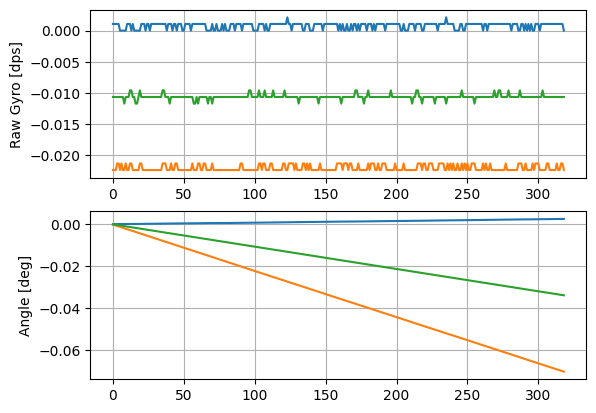

In [57]:
g = np.array([x[3:6] for x in data['data']['imu']])
deg = np.cumsum(g, axis=0) * 1/100

plt.subplot(2,1,1)
plt.plot(g)
plt.grid(True)
plt.ylabel("Raw Gyro [dps]")

plt.subplot(2,1,2)
plt.plot(deg)
plt.grid(True)
plt.ylabel("Angle [deg]")

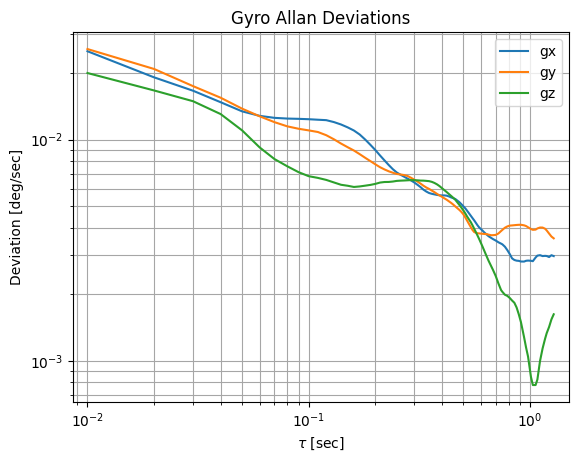

In [41]:
fs = 100
(taux, adx) = AllanDeviation(deg[:,0], fs, maxNumM=200)
(tauy, ady) = AllanDeviation(deg[:,1], fs, maxNumM=200)
(tauz, adz) = AllanDeviation(deg[:,2], fs, maxNumM=200)

# Plot data on log-scale
plt.plot(taux, adx, label='gx')
plt.plot(tauy, ady, label='gy')
plt.plot(tauz, adz, label='gz')
plt.xlabel(r'$\tau$ [sec]')
plt.title('Gyro Allan Deviations')
plt.ylabel('Deviation [deg/sec]')
plt.grid(True, which="both", ls="-", color='0.65')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.axis('equal');

If a sensor has Gaussian white noise, then the slope of the lines should be -0.5 (or a rough linear line going from top left to bottom right on the log-log plot).



# Appendix A: Integrating Random Noise

If the mean value of the noise is anything other than 0, then the integration will increase.

- negative mean, decrease negatively
- positive mean, increase positively

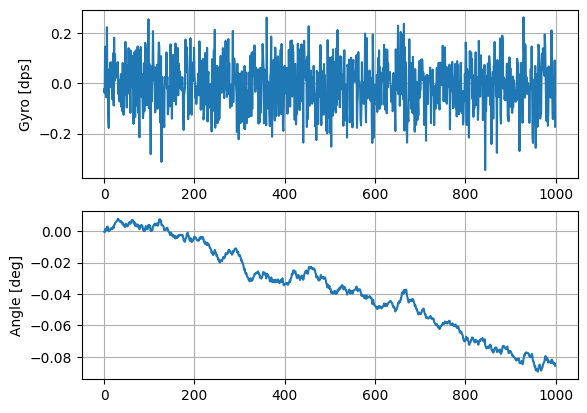

In [56]:
gyro = np.random.normal(-0.01,.1,1000)
angle = np.cumsum(gyro) * 1/100

plt.subplot(2,1,1)
plt.plot(gyro)
plt.grid(True)
plt.ylabel("Gyro [dps]")

plt.subplot(2,1,2)
plt.plot(angle)
plt.grid(True)
plt.ylabel("Angle [deg]");